**Background Information for Data Set**<br>
The labeled data set consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. In addition, there are another 50,000 IMDB reviews provided without any rating labels.

The data set was obtained from Kaggle. Below are teh field definitions provided for the data set.
 - id - Unique ID of each review
 - sentiment - Sentiment of the review; 1 for positive reviews and 0 for negative reviews
 - review - Text of the review

## Part 1: Get the Stemmed Data Obtained in Week 3

In [85]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import unicodedata
import sys
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

### Step 1: Import movie data and ensure the data loads properly.

In [86]:
# Load the training data set containing 25k reviews.

FILE = 'labeledTrainData.tsv'

review_df = pd.read_csv(FILE, sep='\t')

In [87]:
review_df.head() # Check to ensure the file loaded properly.

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [88]:
# Grouping and coutning of sentiment scores.

review_df.groupby('sentiment')['id'].count()

sentiment
0    12500
1    12500
Name: id, dtype: int64

### Processing 1 - Convert all text to lowercase letters.

In [89]:
# Convert text to lower case. 

review_df['review'] = review_df['review'].apply(lambda x: str.lower(x))

### Processing 2 - Remove punctuation, numbers, and special characters from the text.

In [90]:
# Use Regex to eliminate all non-characters and non-numerics.

# Create a dictionary of punctuation using unicode
punctuation = dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P'))

# Remove punctuation from our 'review_clean' field
review_df['review'] = [string.translate(punctuation) for string in review_df['review']]

# Remove page breaks from words "<br >"
review_df['review'] = review_df['review'].apply(lambda t: re.sub('<br >','',t))

# Remove numbers from 'review' column
review_df['review'] = review_df['review'].apply(lambda x: re.sub(r"\d+", "", x))

In [91]:
review_df.head(10)

,id,sentiment,review
0,5814_8,1,with all this stuff going down at the moment w...
1,2381_9,1,the classic war of the worlds by timothy hines...
2,7759_3,0,the film starts with a manager nicholas bell g...
3,3630_4,0,it must be assumed that those who praised this...
4,9495_8,1,superbly trashy and wondrously unpretentious s...
5,8196_8,1,i dont know why people think this is such a ba...
6,7166_2,0,this movie could have been very good but comes...
7,10633_1,0,i watched this video at a friends house im gla...
8,319_1,0,a friend of mine bought this film for £ and ev...
9,8713_10,1,this movie is full of references like mad max ...


### Processing 3 - Remove Stop Words

In [92]:
# Tokenize word groups in 'review' using NLTK.

review_df['review_wordtokens'] = [word_tokenize(w) for w in review_df['review']]

In [93]:
# Download NLTK's library of stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dfgpr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [94]:
# Import stopwords from NLTK
stop_words = stopwords.words('english')

# Remove stop words. Need to iterate over words in 'review_wordtokens' using apply as it is a list.
review_df['review_wordtokens'] = review_df['review_wordtokens'].apply(lambda x: 
                                                       [word for word in x if word not in stop_words])

In [95]:
review_df['review_wordtokens'].head(10)

0    [stuff, going, moment, mj, ive, started, liste...
1    [classic, war, worlds, timothy, hines, enterta...
2    [film, starts, manager, nicholas, bell, giving...
3    [must, assumed, praised, film, greatest, filme...
4    [superbly, trashy, wondrously, unpretentious, ...
5    [dont, know, people, think, bad, movie, got, p...
6    [movie, could, good, comes, way, short, cheesy...
7    [watched, video, friends, house, im, glad, was...
8    [friend, mine, bought, film, £, even, grossly,...
9    [movie, full, references, like, mad, max, ii, ...
Name: review_wordtokens, dtype: object

### Processing 4 - Apply NLTK’s PorterStemmer

In [96]:
# Create stemmer
porter = PorterStemmer()

# Iterate over 'review_wordtokens' and apply Stemming

review_df['review_wordtokens'] = review_df['review_wordtokens'].apply(lambda x: [porter.stem(word) for word in x])

### Processing 5 - Rejoin List of Elements 

In [97]:
# Use sklearn to vectorize model. Since the words are separated in an individual list, the first step requires
# us to rejoin the individual words into a grouped cell.

# Join list elements for model
review_df['review_clean'] = review_df['review_wordtokens'].apply(lambda x: ' '.join(x))

review_df1 = review_df.drop(['review', 'review_wordtokens'], axis=1)

In [98]:
# Validate shape adn structure of dataframe.

print('The number of records in our original dataframe:',review_df1.shape)
review_df1.head()

The number of records in our original dataframe: (25000, 3)


,id,sentiment,review_clean
0,5814_8,1,stuff go moment mj ive start listen music watc...
1,2381_9,1,classic war world timothi hine entertain film ...
2,7759_3,0,film start manag nichola bell give welcom inve...
3,3630_4,0,must assum prais film greatest film opera ever...
4,9495_8,1,superbl trashi wondrous unpretenti exploit hoo...


## Step 2: Split Data into Training and Test Sets

In [99]:
# Split review_df1 into train and test sets
target = review_df1['sentiment']
features = review_df1['review_clean']

features_train, features_test, target_train, target_test = train_test_split(features, target)  # Default test size 25%.

## Step 3: Fit and apply the tf-idf vectorization to the training set.

In [100]:
# Create output of td-idf scores for the movie reviews.

tfidf_vectorizer = TfidfVectorizer()
features_train_tfidf = tfidf_vectorizer.fit_transform(features_train)

## Step 4: Train Logistic Regression Model on Train Set

In [101]:
logistic_regression = LogisticRegression()
lr_model = logistic_regression.fit(features_train_tfidf, target_train)

## Step 5: Find the model accuracy on test set.

In [102]:
# Apply vectorization to test set.
features_test_tfidf = tfidf_vectorizer.transform(features_test)

# Develop predictions in the test set.
target_test_pred = lr_model.predict(features_test_tfidf)

In [103]:
# Compute accuracy score
acc_score = accuracy_score(target_test_pred, target_test)

print(f'Logistic Regression Accuracy Score: {acc_score}')

Logistic Regression Accuracy Score: 0.88112


## Step 6: Create a confusion matrix for the test set predictions.

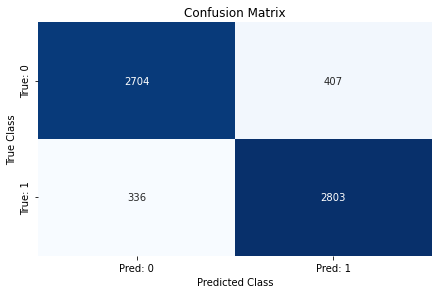

In [104]:
# Calculate confusion matrix.

matrix = confusion_matrix(target_test, target_test_pred)

# Print dataframe with easier to read titles.
dataframe = pd.DataFrame(matrix, index=['True: 0', 'True: 1'], columns=['Pred: 0', 'Pred: 1'])

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues', fmt='d');
plt.title('Confusion Matrix');
plt.tight_layout();
plt.ylabel('True Class');
plt.xlabel('Predicted Class');

## Step 7: Get the precision, recall, and F1-score for the test set predictions.

In [105]:
# Calculate and print metrics.

print(f'Precision Score: {precision_score(target_test, target_test_pred):.4f}')
print(f'Recall Score: {recall_score(target_test, target_test_pred):.4f}')
print(f'F1 Score: {f1_score(target_test, target_test_pred):.4f}')

Precision Score: 0.8732
Recall Score: 0.8930
F1 Score: 0.8830


## Step 8: Create a ROC curve for the test set.

In [106]:
target_test_prob = lr_model.predict_proba(features_test_tfidf)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test, target_test_prob)

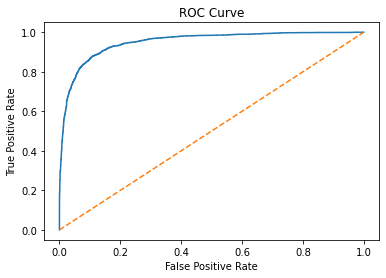

In [107]:
plt.title('ROC Curve');
plt.plot(false_positive_rate, true_positive_rate);
plt.plot([0,1], ls='--');
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

## Step 9: Pick another classification model you learned about this week and repeat steps (5) – (9).

In [108]:
# Build a Random Forest model using earlier data sets. Use vectorized training set.

randomforest = RandomForestClassifier()
rf_model = randomforest.fit(features_train_tfidf, target_train)

# Predict values for test data
target_test_pred_rf = rf_model.predict(features_test_tfidf)

In [109]:
# Compute accuracy score
acc_score = accuracy_score(target_test_pred_rf, target_test)

print(f'Random Forest Accuracy Score: {acc_score}')

Random Forest Accuracy Score: 0.84176


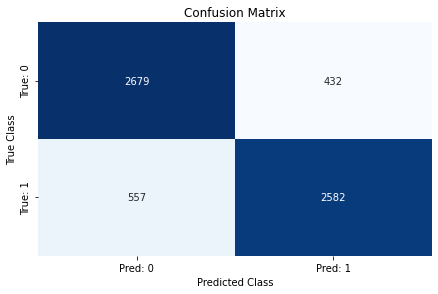

In [110]:
# Calculate confusion matrix.

matrix = confusion_matrix(target_test, target_test_pred_rf)

# Print dataframe with easier to read titles.
dataframe = pd.DataFrame(matrix, index=['True: 0', 'True: 1'], columns=['Pred: 0', 'Pred: 1'])

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues', fmt='d');
plt.title('Confusion Matrix');
plt.tight_layout();
plt.ylabel('True Class');
plt.xlabel('Predicted Class');

In [111]:
# Calculate and print metrics.

print(f'Precision Score: {precision_score(target_test, target_test_pred_rf):.4f}')
print(f'Recall Score: {recall_score(target_test, target_test_pred_rf):.4f}')
print(f'F1 Score: {f1_score(target_test, target_test_pred_rf):.4f}')

Precision Score: 0.8567
Recall Score: 0.8226
F1 Score: 0.8393


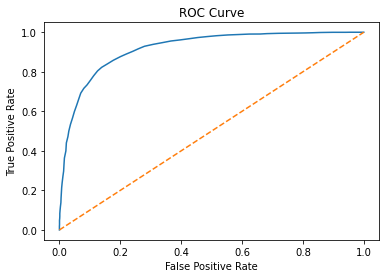

In [112]:
# Create a ROC Curve

# Calculate values for ROC
target_test_prob_rf = rf_model.predict_proba(features_test_tfidf)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test, target_test_prob_rf)

# Print ROC Graph
plt.title('ROC Curve');
plt.plot(false_positive_rate, true_positive_rate);
plt.plot([0,1], ls='--');
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');